In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, Dropout, MaxPool2D, UpSampling2D
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression

In [2]:

#initialize feature names for tfrecord parsing

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph','pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']
FEATURE_VECTOR_SIZE = 64

#declare read in format for tf record parsing per feature
feature_descriptions = {
    'elevation' : tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'th' : tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'vs' : tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'tmmn' : tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'tmmx': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'sph': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'pr': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'pdsi': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'NDVI': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'population': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'erc': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'PrevFireMask': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32),
    'FireMask': tf.io.FixedLenFeature([FEATURE_VECTOR_SIZE, FEATURE_VECTOR_SIZE], tf.float32)
}


In [3]:
#tfrecord files to use for training data
train_dataset = tf.data.TFRecordDataset(["./next_day_wildfire_spread_train_00.tfrecord",
                                       "./next_day_wildfire_spread_train_01.tfrecord",
                                       "./next_day_wildfire_spread_train_02.tfrecord", 
                                       "./next_day_wildfire_spread_train_03.tfrecord", 
                                       "./next_day_wildfire_spread_train_04.tfrecord"])

validation_dataset = tf.data.TFRecordDataset([
    './next_day_wildfire_spread_eval_00.tfrecord',
    './next_day_wildfire_spread_eval_01.tfrecord'
])

In [4]:
#given a sample from a tf record, read in the data according to the feature descriptions declared above
def parse_dataset(data_sample):
    features = tf.io.parse_single_example(data_sample, feature_descriptions)
    inputs_list = [features.get(key) for key in INPUT_FEATURES]

    stacked_inputs = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(stacked_inputs, [1,2,0])

    print(input_img.shape)

    outputs_list = [features.get(key) for key in OUTPUT_FEATURES]

    assert outputs_list, 'outputs_list should not be empty'
    
    outputs_stacked = tf.stack(outputs_list, axis=0)
    output_img = tf.transpose(outputs_stacked, [1,2,0])

    return input_img, output_img

In [5]:
#for tf records get samples by calling parse_dataset
def get_dataset(dataset_tfrecords):

    dataset = dataset_tfrecords.map(
        lambda x : parse_dataset(x)
    )
    
    return dataset

(64, 64, 12)
(64, 64, 12)
training batch (64, 64, 12)
(64, 64, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


2025-05-22 09:42:06.234957: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


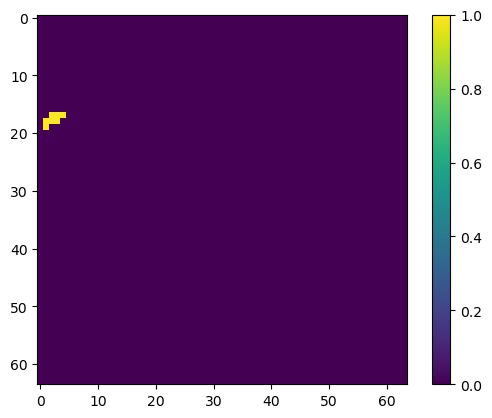

2025-05-22 09:42:06.674477: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
#train val split
training_set = get_dataset(train_dataset)
validation_set = get_dataset(validation_dataset)
training_batches = training_set.batch(32)
val_batches = validation_set.batch(32)

for batch in training_set.take(1):
    print(f"training batch {batch[0].shape}")
    print(batch[1].shape)
    print(np.squeeze(batch[1]))
    plt.imshow(np.squeeze(batch[1]), cmap='viridis')
    plt.colorbar()
    plt.show()

In [64]:
#time to build the model -- we use another script instead to run the model
autoencoder = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(64,64,12)),
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', strides=(1,1)),

    #main block one
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    MaxPool2D(2,2),
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', strides=(1,1)),
    Dropout(rate=0.1),

    #main block 2
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    MaxPool2D(2,2),
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(1,1)),
    Dropout(rate=0.1),

    #upsample
    UpSampling2D(),

    #main block 3
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    # MaxPool2D(2,2),
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(1,1)),
    Dropout(rate=0.1),

    UpSampling2D(),

    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    # MaxPool2D(2,2),
    LeakyReLU(alpha=0.1),
    Dropout(rate=0.1),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', strides=(1,1)),
    Dropout(rate=0.1),

    #fin
    Conv2D(filters=1, kernel_size=(3,3), padding='same', strides=(1,1))
])


In [65]:
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 16)     │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 32)     │             

 Total params: 25,041 (97.82 KB)

 Trainable params: 25,041 (97.82 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
def weighted_loss(pos_weight):
    def loss_fn(y_true, y_pred):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(
            labels=y_true,
            logits=y_pred,
            pos_weight=pos_weight
        ))
    return loss_fn

In [83]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(
    optimizer=optimizer,
    loss=weighted_loss(20.0),
    metrics=[
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = autoencoder.fit(training_batches, validation_data=val_batches, epochs=50)

Epoch 1/50
      3/Unknown 2s 41ms/step - auc: 0.4999 - loss: -20640184664064.0000 - precision: 0.0000e+00 - recall: 0.0000e+00

E0000 00:00:1746677971.946410  989847 meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_1_1/leaky_re_lu_9_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_1_1/conv2d_7_1/BiasAdd'.


    156/Unknown 9s 49ms/step - auc: 0.4996 - loss: -7460247044096.0000 - precision: 0.0050 - recall: 1.0642e-04     

/Users/924322786/.conda/envs/fire_testing/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - auc: 0.4996 - loss: -7467863900160.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -4462998978560.0000 - val_precision: 0.0193 - val_recall: 4.2011e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - auc: 0.4996 - loss: -8663345397760.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -5186459795456.0000 - val_precision: 0.0193 - val_recall: 4.2011e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - auc: 0.4996 - loss: -10038406021120.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -6054365102080.0000 - val_precision: 0.0193 - val_recall: 4.2011e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - auc: 0.4996 - loss: -11746568830976.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -7097363726336.0000 - val_precision: 0.0193 - val_recall: 4.2011e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - auc: 0.4

2025-05-07 21:21:01.416183: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - auc: 0.4996 - loss: -22552479006720.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -13769858088960.0000 - val_precision: 0.0193 - val_recall: 4.2011e-04
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - auc: 0.4996 - loss: -26762469703680.0000 - precision: 0.0049 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -16303788130304.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - auc: 0.4996 - loss: -31635751829504.0000 - precision: 0.0050 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -19294092001280.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - auc: 0.4996 - loss: -37496335368192.0000 - precision: 0.0051 - recall: 1.0867e-04 - val_auc: 0.4998 - val_loss: -22817011662848.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - 

2025-05-07 21:27:56.702970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - auc: 0.4996 - loss: -1587886453424128.0000 - precision: 0.0050 - recall: 1.0867e-04 - val_auc: 0.4998 - val_loss: -914730055106560.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 41/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - auc: 0.4996 - loss: -1754966318383104.0000 - precision: 0.0051 - recall: 1.0867e-04 - val_auc: 0.4998 - val_loss: -1003035388018688.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 42/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - auc: 0.4996 - loss: -1918386871205888.0000 - precision: 0.0049 - recall: 1.0603e-04 - val_auc: 0.4998 - val_loss: -1098118850412544.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 43/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - auc: 0.4996 - loss: -2104531424903168.0000 - precision: 0.0051 - recall: 1.0867e-04 - val_auc: 0.4998 - val_loss: -1200586703765504.0000 - val_precision: 0.0194 - val_recall: 4.2011e-04
Epoch 44/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 

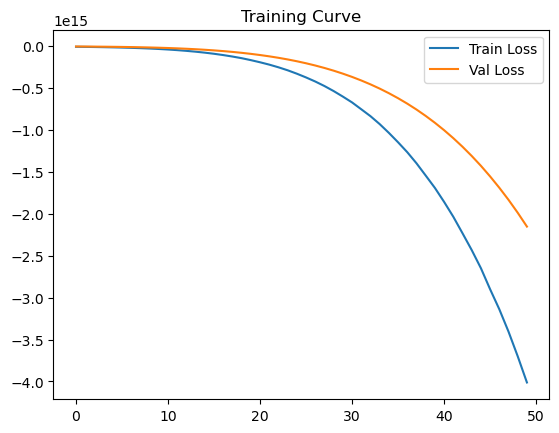

In [84]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curve")
plt.show()

(64, 64, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


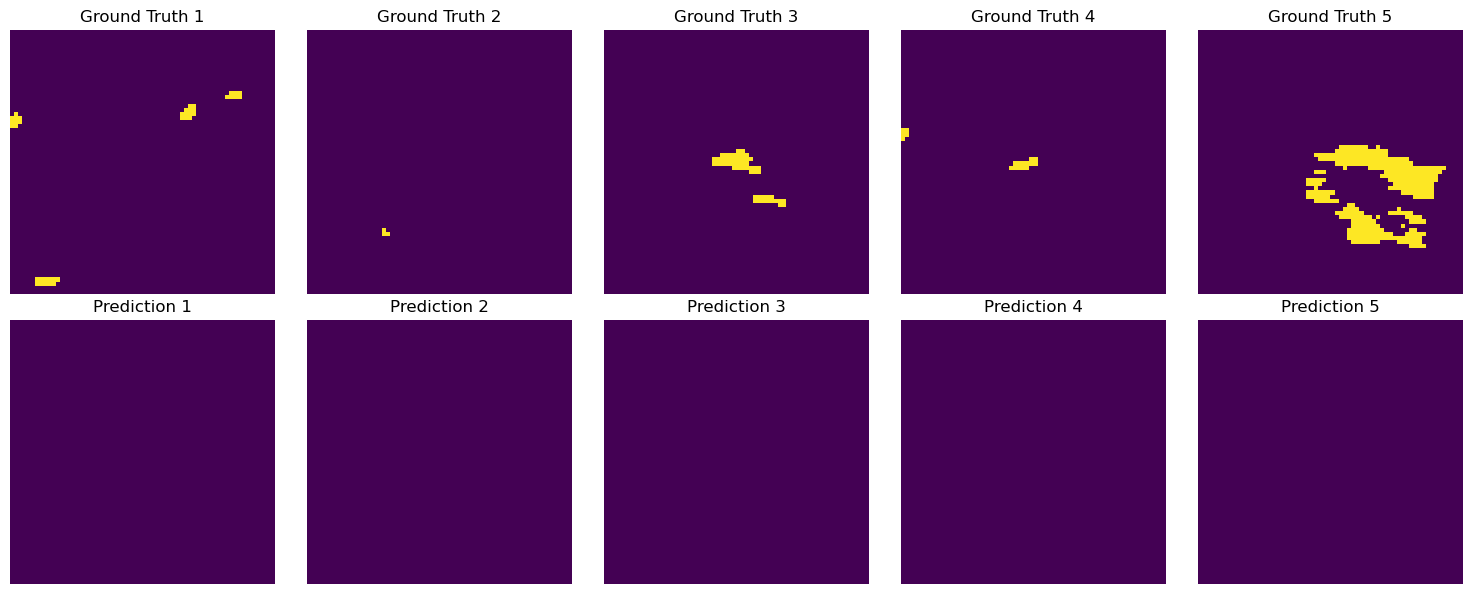

hello world


In [85]:
test_dataset = tf.data.TFRecordDataset(['./next_day_wildfire_spread_eval_00.tfrecord'])
test_set = get_dataset(test_dataset)

# for sample, label in test_set.take(1):
#     print(f'sample shape: {sample.shape}')
#     print(f'label shape: {label.shape}')
#     sample = np.expand_dims(sample, axis=0)
#     pred = autoencoder.predict(sample)

# print(f"Output shape: {pred.shape}")
# prob = tf.sigmoid(pred)[0, :, :, 0]
# output_image = tf.cast(prob > 0.5, tf.float32)

# plt.imshow(output_image, cmap='viridis')
# plt.title("Fire Prediction Map")
# plt.colorbar()
# plt.show()

NUM_SAMPLES = 5
predicted_maps = []
ground_truth_maps = []

for sample, label in test_set:
    label_np = np.squeeze(label.numpy())
    if np.any(label_np == 1):
        sample_batch = np.expand_dims(sample, axis=0)
        pred = autoencoder.predict(sample_batch)
        prob = tf.sigmoid(pred)[0, :, :, 0]
        output_image = tf.cast(prob > 0.5, tf.float32)

        predicted_maps.append(output_image.numpy())
        ground_truth_maps.append(label_np)

    if len(predicted_maps) == NUM_SAMPLES:
        break

fig, axes = plt.subplots(nrows=2, ncols=NUM_SAMPLES, figsize=(NUM_SAMPLES * 3, 6))

for i in range(NUM_SAMPLES):
    # Ground Truth
    axes[0, i].imshow(ground_truth_maps[i], cmap='viridis', vmin=0, vmax=1)
    axes[0, i].set_title(f"Ground Truth {i+1}")
    axes[0, i].axis('off')

    # Prediction
    axes[1, i].imshow(predicted_maps[i], cmap='viridis', vmin=0, vmax=1)
    axes[1, i].set_title(f"Prediction {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
print("hello world")

### Traditional Machine Learning Methods

In [7]:
# form the training set by taking 3x3 windows over samples
def extract_balanced_samples(X_pt, Y_map, num_samples=None):
    H, W, C = X_pt.shape
    assert(H, W) == Y_map.shape

    #3x3 sliding not fully compatible with 64x64 so we pad
    padded_x = np.pad(X_pt, ((1,1), (1,1), (0,0)), mode='reflect')

    #offsets for forming 3x3 window
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),  (0, 0),  (0, 1),
               (1, -1),  (1, 0),  (1, 1)]

    pos_coords = np.argwhere(Y_map == 1)
    neg_coords = np.argwhere(Y_map == 0)

    if num_samples is None:
        num_samples = min(len(pos_coords), len(neg_coords))

    pos_coords = shuffle(pos_coords)[:num_samples]
    neg_coords = shuffle(neg_coords)[:num_samples]

    total_samples = 2 * num_samples
    X_out = np.zeros((total_samples, 108), dtype=np.float32)
    Y_out = np.zeros(total_samples, dtype=np.int8)

    def extract_patch(i, j):
        return np.concatenate([padded_x[i + dy + 1, j + dx + 1] for dy, dx in offsets])

    for idx, (i, j) in enumerate(np.vstack((pos_coords, neg_coords))):
        X_out[idx] = extract_patch(i, j)
        Y_out[idx] = 1 if idx < num_samples else 0
    
    return shuffle(X_out, Y_out)
    
#makes tf dataset type into a numpy multidimensional matrix so we can use with sklearn
def tf_to_np_dataset(dataset, max_samples=None):
    X_list, Y_list = [], []

    for i, (input_img, output_img) in enumerate(dataset):
        
        if max_samples and i >= max_samples:
            break
        
        X_np = input_img.numpy()
        Y_np = output_img.numpy().squeeze()
        
        features, labels = extract_balanced_samples(X_np, Y_np)
        X_list.append(features)
        Y_list.append(labels)

    X_all = np.vstack(X_list)
    Y_all = np.hstack(Y_list)

    return X_all, Y_all
    

In [8]:
training_set_for_ml = get_dataset(train_dataset)
validation_set_for_ml = get_dataset(validation_dataset)

X_train, y_train = tf_to_np_dataset(training_set_for_ml, max_samples=300)
X_val, y_val = tf_to_np_dataset(validation_set_for_ml, max_samples=100)

rand_forest_clf = RandomForestClassifier(
    max_depth=20
)

rand_forest_clf.fit(X_train, y_train)
y_pred = rand_forest_clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["No fire", "Fire"]))
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


(64, 64, 12)
(64, 64, 12)
              precision    recall  f1-score   support

     No fire       0.54      0.97      0.69      5386
        Fire       0.85      0.17      0.28      5386

    accuracy                           0.57     10772
   macro avg       0.69      0.57      0.49     10772
weighted avg       0.69      0.57      0.49     10772

0.5687894541403639


In [9]:
log_reg = LogisticRegression(penalty=None).fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["No fire", "Fire"]))
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


              precision    recall  f1-score   support

     No fire       0.51      0.22      0.31      5386
        Fire       0.50      0.79      0.61      5386

    accuracy                           0.51     10772
   macro avg       0.51      0.51      0.46     10772
weighted avg       0.51      0.51      0.46     10772

0.5052914964723357


/Users/924322786/.conda/envs/fire_testing/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
support_vm = svm.SVC()
support_vm.fit(X_train, y_train)
y_pred = support_vm.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["No fire", "Fire"]))
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


              precision    recall  f1-score   support

     No fire       0.57      0.30      0.40      5386
        Fire       0.52      0.77      0.62      5386

    accuracy                           0.54     10772
   macro avg       0.55      0.54      0.51     10772
weighted avg       0.55      0.54      0.51     10772

0.5364834756776828


In [11]:
gradient_boosted = GradientBoostingClassifier(
    n_estimators=200
).fit(X_train, y_train)

y_pred = gradient_boosted.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["No fire", "Fire"]))
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

              precision    recall  f1-score   support

     No fire       0.54      0.96      0.69      5386
        Fire       0.81      0.18      0.30      5386

    accuracy                           0.57     10772
   macro avg       0.67      0.57      0.49     10772
weighted avg       0.67      0.57      0.49     10772

0.5697177868548088


In [12]:
#extract all 3x3 patches for a particular data point
def extract_all_patches(data_pt):
    H, W, C = data_pt.shape
    assert (H, W, C) == (64, 64, 12)

    padded = np.pad(data_pt, ((1,1), (1,1), (0,0)), mode='reflect')
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),  (0, 0),  (0, 1),
               (1, -1),  (1, 0),  (1, 1)]

    all_patches = np.zeros((H * W, 108), dtype=np.float32)

    idx = 0
    for i in range(1, H+1):
        for j in range(1, W+1):
            patch = [padded[i+dy, j+dx] for dy, dx in offsets]
            all_patches[idx] = np.concatenate(patch)
            idx += 1
    return all_patches

In [18]:
#we need to predict a map based on all 3x3x12 patches extracted and make a prediction for each patch
#reshape into a 64x64 for prediction which forms our map and then visualize
def predict_entire_fire_map_ml(model):
    val_dataset = get_dataset(validation_dataset)
    NUM_MAPS = 5
    ground_truth_maps = []
    predicted_maps = []
    probability_maps = []
    
    for input_img, output_img in val_dataset:
        curr_ground_truth = np.squeeze(output_img.numpy())
    
        if np.any(curr_ground_truth == 1):
            curr_X_test = extract_all_patches(input_img.numpy())
        
            curr_y_pred = model.predict(curr_X_test)
            curr_pred_map = curr_y_pred.reshape(64,64)

            # curr_y_prob = model.predict_proba(curr_X_test)
            # curr_prob_map = curr_y_prob[:, 1].reshape(64, 64)
        
            ground_truth_maps.append(np.squeeze(output_img.numpy()))        
            predicted_maps.append(curr_pred_map)
            # probability_maps.append(curr_prob_map)
        
        if len(ground_truth_maps) == NUM_MAPS:
            break
    
    
    fig, axes = plt.subplots(nrows=2, ncols=NUM_MAPS, figsize=(15, 10))
    
    for i in range(5):
        axes[0, i].imshow(ground_truth_maps[i], cmap='viridis', vmin=0, vmax=1)
        axes[0, i].set_title(f"Ground Truth {i+1}")
        
        axes[1, i].imshow(predicted_maps[i], cmap='viridis', vmin=0, vmax=1)
        axes[1, i].set_title(f"Prediction {i+1}")

        # prob_map = probability_maps[i]
        # im = axes[2, i].imshow(prob_map, cmap='jet', vmin=0, vmax=1)
        # axes[2, i].set_title(f"Fire Probability {i+1}")
        # axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

(64, 64, 12)


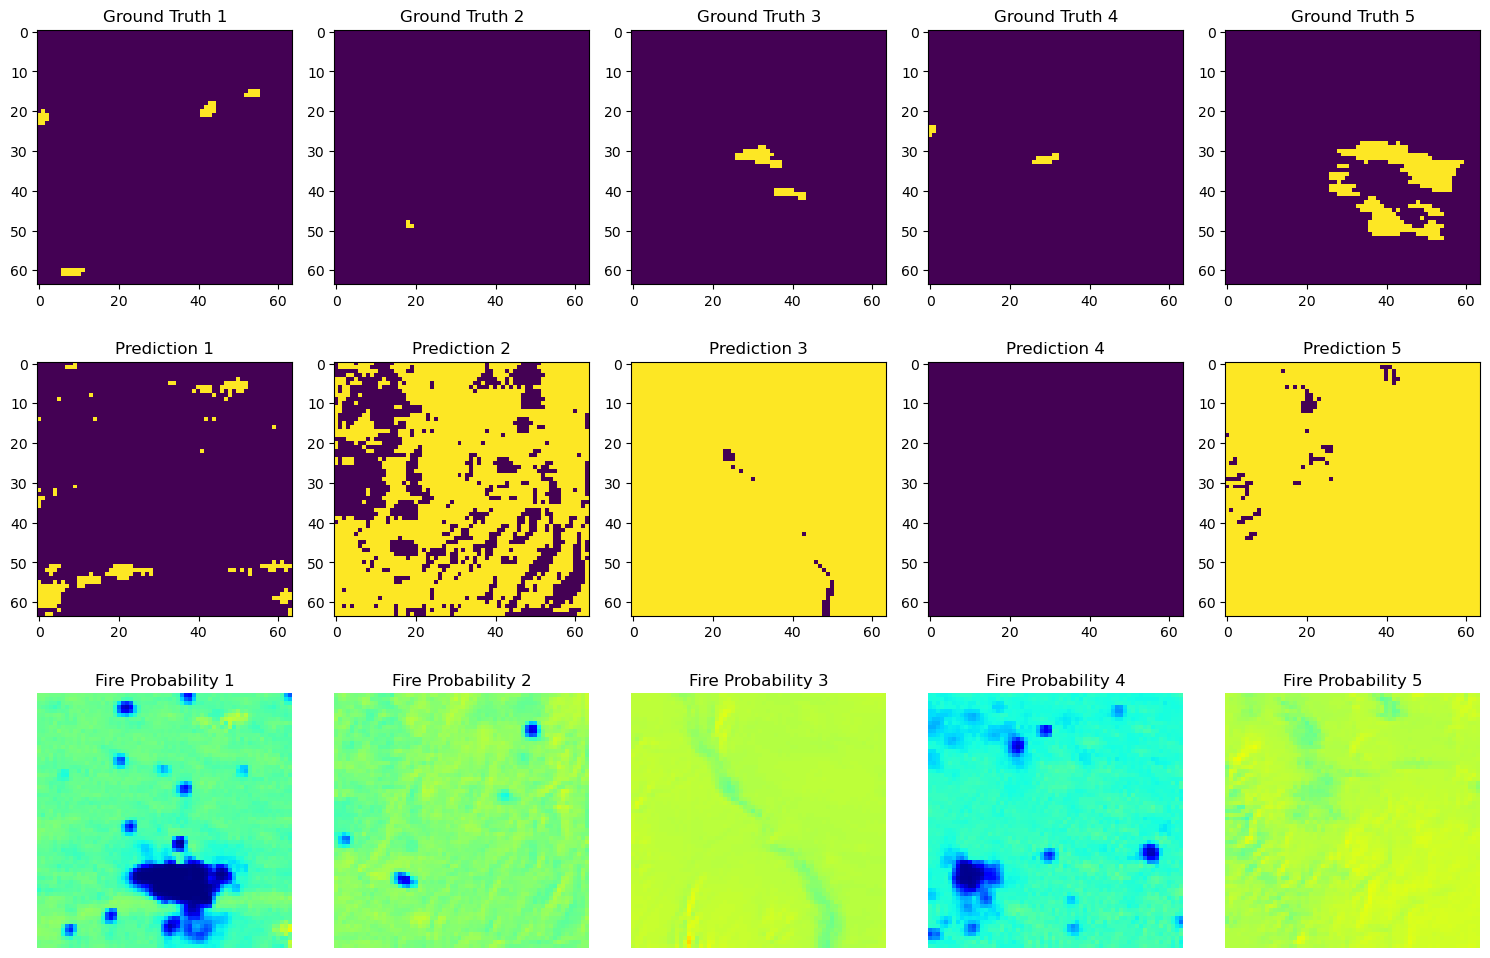

In [14]:
predict_entire_fire_map_ml(log_reg)

(64, 64, 12)


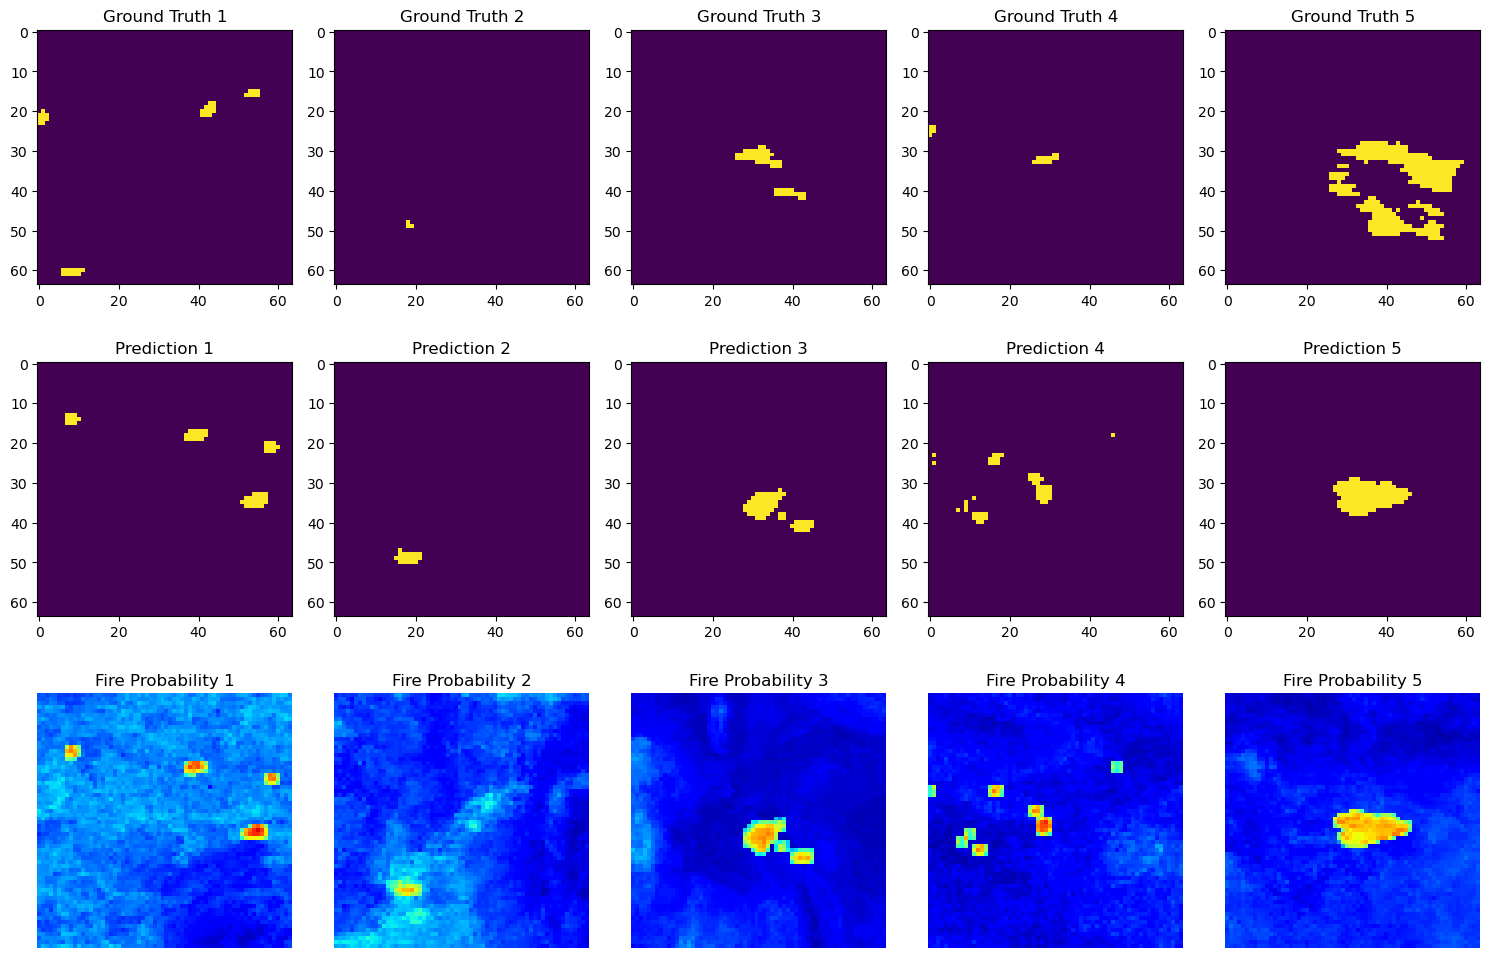

In [15]:
predict_entire_fire_map_ml(rand_forest_clf)

(64, 64, 12)


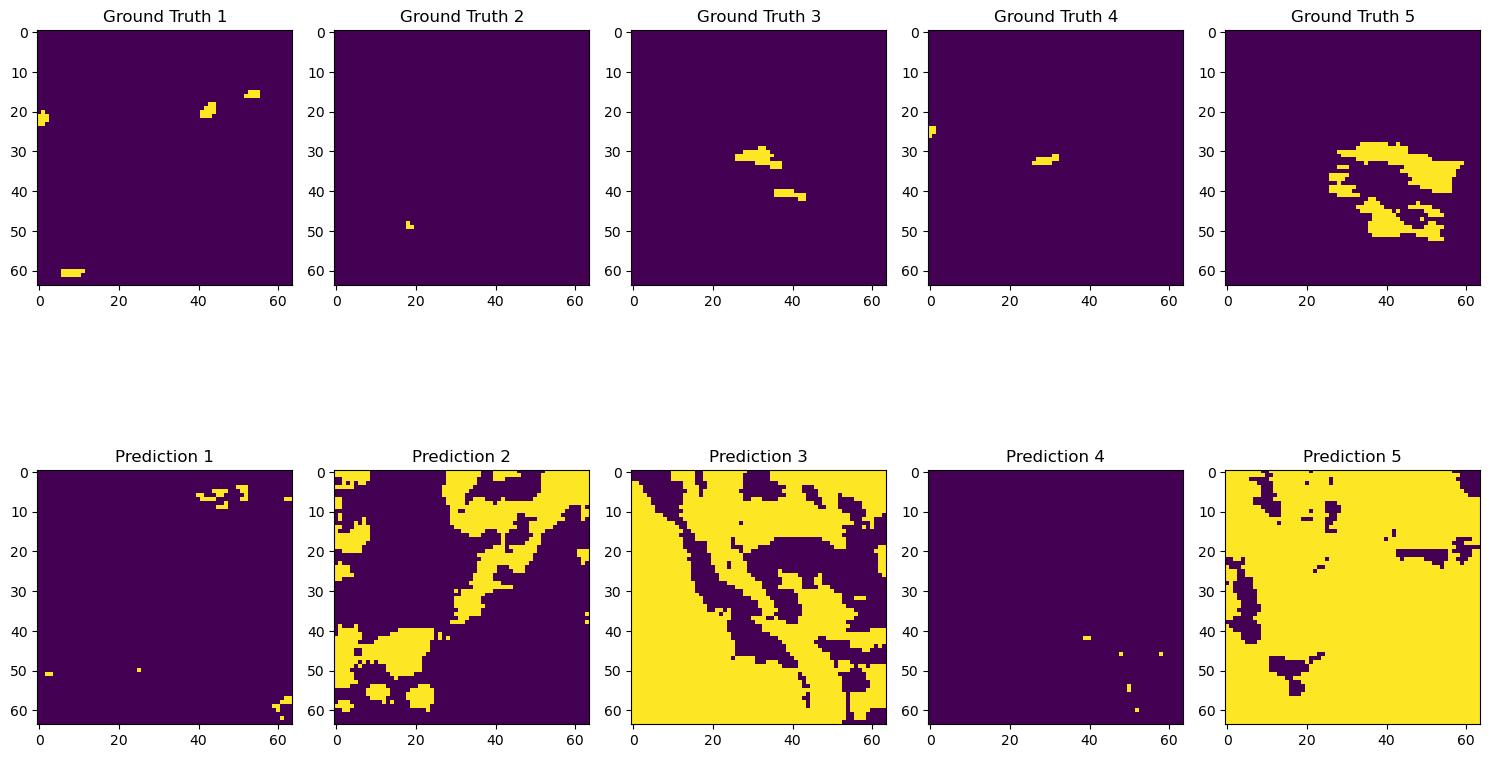

In [19]:
predict_entire_fire_map_ml(support_vm)

(64, 64, 12)


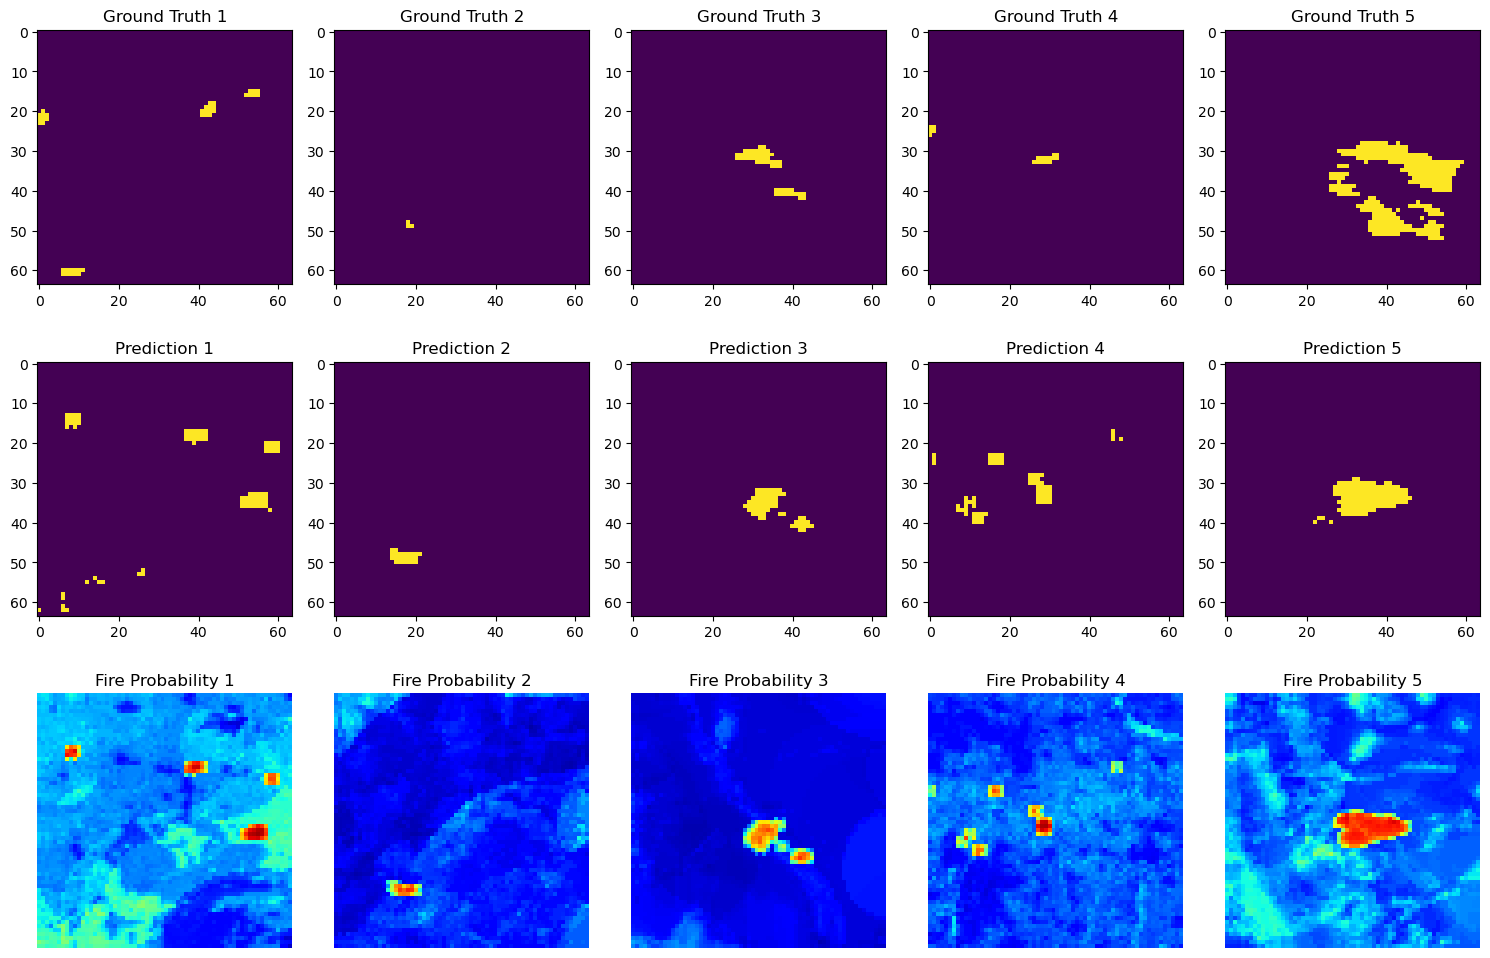

In [17]:
predict_entire_fire_map_ml(gradient_boosted)

### Extra random code that no longer use

In [ ]:
for raw_record in train_dataset.take(1):  
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for key in example.features.feature.keys():
        values = example.features.feature[key].float_list.value
        array = np.array(values)
        print(type(array[0]))
        
        print(f"Feature: {key}, Shape: {array.shape}")

In [ ]:
for raw_record in train_dataset.take(1):  
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    feature_keys = list(example.features.feature.keys())  
    num_features = len(feature_keys)

    data_array = np.zeros((64, 64, num_features))

    for i, key in enumerate(feature_keys):
        values = example.features.feature[key].float_list.value
        feature_array = np.array(values).reshape(64, 64)
        data_array[:, :, i] = feature_array 

    num_cols = 5
    num_rows = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 9))
    
    axes = axes.flatten()

    for i in range(num_features): 
        ax = axes[i]
        ax.imshow(data_array[:, :, i], cmap="viridis", aspect="auto") 
        ax.set_title(feature_keys[i]) 
        ax.axis("off")

    for j in range(num_features, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
data_blob = tf.data.TFRecordDataset("./next_day_wildfire_spread_train_00.tfrecord")
num_samples = sum(1 for _ in data_blob)
print(f"Total number of samples in tfrecord: {num_samples}")

In [ ]:
data_blob = tf.data.TFRecordDataset("./next_day_wildfire_spread_eval_01.tfrecord")
num_samples = sum(1 for _ in data_blob)
print(f"Total number of samples in tfrecord: {num_samples}")

In [ ]:
data_blob = tf.data.TFRecordDataset("./next_day_wildfire_spread_test_01.tfrecord")
num_samples = sum(1 for _ in data_blob)
print(f"Total number of samples in tfrecord: {num_samples}")

In [ ]:
def get_base_key(key):
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))

In [ ]:
def get_features_dict(sample_size, features):
    sample_shape = [sample_size, sample_size]

    features = set(features)

    columns = [tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32) for _ in features]
    return dict(zip(features, columns))

In [ ]:
def parse_fn(
    example_proto, data_size, sample_size, num_in_channels, clip_and_normalize, clip_and_rescale, random_crop, center_crop
):
    if random_crop and center_crop:
        raise ValueError('Cannot have both random_crop and center crop be True')

    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    inputs_list = [features.get(key) for key in input_features]
    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1,2,0])

    outputs_list = [features.get(key) for key in output_features]
    outputs_stacked=tf.stack(output_list, axis=0)
    output_img = tf.transpose(outputs_stacked, [1,2,0])

    return input_img, output_img

In [ ]:
def get_dataset(file_pattern, data_size, sample_size, batch_size, num_in_channels, compression_type, clip_and_normalize, clip_and_rescale, random_crop, center_crop):
    dataset = tf.data.Dataset.list_files(file_pattern)
    
    dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    

In [ ]:
tfrecord_file = './next_day_wildfire_spread_train_00.tfrecord'

# Load TFRecord dataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)